# NCBI id to Ensemble id

In [102]:
import csv
import pandas as pd
import numpy as np
from Bio import Entrez
import matplotlib_venn

In [103]:
xls = pd.read_excel("Negative_Positive_genes.xlsx", sheet_name=1)
NCBI_id = xls["gene id"].astype(str).to_list()

In [104]:
print(f'There are {len(NCBI_id)} negative genes')

There are 1189 negative genes


In [105]:
xls.head(10)

,gene id,symbol
0,10002,NR2E3
1,10008,KCNE3
2,100133941,CD24
3,10019,SH2B3
4,10020,GNE
5,10021,HCN4
6,10046,MAMLD1
7,100506658,OCLN
8,10060,ABCC9
9,10083,USH1C


In [106]:
# check null values
xls.isnull().sum()

gene id    0
symbol     0
dtype: int64

pip install mygene


Mygene looks like a promising package to use for this task.  
- https://docs.mygene.info/projects/mygene-py/en/latest/#optional-dependencies  package documentation  
- https://www.kaggle.com/code/alexandervc/genes-info-with-mygene-python-package kaggle tutorial

In [107]:
import mygene

mg = mygene.MyGeneInfo()

g = mg.getgene(3507)
print( g.keys() )

dict_keys(['AllianceGenome', 'HGNC', 'MIM', '_id', '_version', 'accession', 'alias', 'clingen', 'ensembl', 'entrezgene', 'generif', 'genomic_pos', 'go', 'map_location', 'name', 'other_names', 'pantherdb', 'pathway', 'pharmgkb', 'pharos', 'reagent', 'refseq', 'reporter', 'retired', 'summary', 'symbol', 'taxid', 'type_of_gene', 'umls', 'unigene', 'wikipedia'])


In [108]:
print( g['ensembl'] )
print( len(g['ensembl']) )
print(type(g['ensembl']))

{'gene': 'ENSG00000211899', 'protein': ['ENSP00000375001', 'ENSP00000490253'], 'transcript': ['ENST00000390559', 'ENST00000637539'], 'translation': [{'protein': 'ENSP00000490253', 'rna': 'ENST00000637539'}, {'protein': 'ENSP00000375001', 'rna': 'ENST00000390559'}], 'type_of_gene': 'IG_C_gene'}
5
<class 'dict'>


## 1 create a dataset with NCBI id and Ensemble id

In [24]:
NCBI_dict = {}

for gene in NCBI_id:
    try:
        g = mg.getgene(gene)
        if isinstance(g['ensembl'], list):
            gene_list = []
            for entry in g['ensembl']:
                gene_list.append(entry['gene'])
            NCBI_dict[gene] = gene_list
        else:
            NCBI_dict[gene] = g['ensembl']['gene']
    except:
        print(f'gene {gene} not found')
        NCBI_dict[gene] = 'not found'
        continue
    



gene 6315 not found


In [44]:
NCBI_df = pd.DataFrame.from_dict(NCBI_dict, orient='index')

# rename the columns on the NCBI_df
NCBI_df.columns = ['Ensembl ID']


display(NCBI_df.head(10))
print(NCBI_df.shape)


,Ensembl ID
10002,ENSG00000278570
10008,ENSG00000175538
100133941,ENSG00000272398
10019,ENSG00000111252
10020,ENSG00000159921
10021,ENSG00000138622
10046,ENSG00000013619
100506658,"[ENSG00000197822, ENSG00000273814]"
10060,ENSG00000069431
10083,ENSG00000006611


(1189, 1)


In [77]:
NCBI_df["Ensembl ID"].str.contains(",").isna().sum()

NCBI_df[NCBI_df["Ensembl ID"].str.contains(",").isna()]

,Ensembl ID
100506658,"[ENSG00000197822, ENSG00000273814]"
1028,"[ENSG00000129757, ENSG00000273707]"
10466,"[ENSG00000164597, ENSG00000284369]"
10594,"[ENSG00000174231, ENSG00000274442]"
10801,"[ENSG00000282302, ENSG00000184640]"
...,...
8622,"[ENSG00000284762, ENSG00000113231]"
8754,"[ENSG00000168615, ENSG00000282230]"
8878,"[ENSG00000161011, ENSG00000284099]"
94137,"[ENSG00000183638, ENSG00000292297]"


#### Since only 1 gene had no Ensemble id, it was removed


- gene 6315 not found

In [79]:
print(NCBI_df.loc['9842'].tolist())
#NCBI_df.drop('6315', inplace=True)


[['ENSG00000225190', 'ENSG00000276358', 'ENSG00000277111']]


# G Profiler

In [111]:
xls['symbol']= xls['symbol'].astype(str)
xls

,gene id,symbol
0,10002,NR2E3
1,10008,KCNE3
2,100133941,CD24
3,10019,SH2B3
4,10020,GNE
...,...,...
1184,9939,RBM8A
1185,9950,GOLGA5
1186,999,CDH1
1187,9992,KCNE2


In [120]:
from gprofiler import GProfiler

gp = GProfiler(return_dataframe=True)
gp_convert_df =gp.convert(organism  = 'hsapiens',
                            query= xls['symbol'].to_list(),
                                target_namespace= 'ENSG')
gp_convert_df

,incoming,converted,n_incoming,n_converted,name,description,namespaces,query
0,NR2E3,ENSG00000278570,1,1,NR2E3,nuclear receptor subfamily 2 group E member 3 ...,"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE",query_1
1,KCNE3,ENSG00000175538,2,1,KCNE3,potassium voltage-gated channel subfamily E re...,"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE",query_1
2,CD24,ENSG00000272398,3,1,CD24,CD24 molecule [Source:HGNC Symbol;Acc:HGNC:1645],"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE",query_1
3,SH2B3,ENSG00000111252,4,1,SH2B3,SH2B adaptor protein 3 [Source:HGNC Symbol;Acc...,"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE",query_1
4,GNE,ENSG00000159921,5,1,GNE,glucosamine (UDP-N-acetyl)-2-epimerase/N-acety...,"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE",query_1
...,...,...,...,...,...,...,...,...
1199,RBM8A,ENSG00000265241,1185,1,RBM8A,RNA binding motif protein 8A [Source:HGNC Symb...,"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE",query_1
1200,GOLGA5,ENSG00000066455,1186,1,GOLGA5,golgin A5 [Source:HGNC Symbol;Acc:HGNC:4428],"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE",query_1
1201,CDH1,ENSG00000039068,1187,1,CDH1,cadherin 1 [Source:HGNC Symbol;Acc:HGNC:1748],"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE",query_1
1202,KCNE2,ENSG00000159197,1188,1,KCNE2,potassium voltage-gated channel subfamily E re...,"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE",query_1


In [121]:
gp_convert_df["incoming"].value_counts().head(10)

MKKS        3
SMN1        2
HPS1        2
FOXP3       2
HLA-DQA1    2
HBA2        2
HBA1        2
CARD9       2
SMN2        2
TREX1       2
Name: incoming, dtype: int64

In [122]:
a= gp_convert_df[gp_convert_df["incoming"]=='MKKS']
a

,incoming,converted,n_incoming,n_converted,name,description,namespaces,query
1073,MKKS,ENSG00000125863,1062,1,MKKS,MKKS centrosomal shuttling protein [Source:HGN...,"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE",query_1
1074,MKKS,ENSG00000285508,1062,2,MKKS,MKKS centrosomal shuttling protein [Source:NCB...,"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE",query_1
1075,MKKS,ENSG00000285723,1062,3,MKKS,MKKS centrosomal shuttling protein [Source:NCB...,"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE",query_1


## Compare the NCBI dataset with the Ensemble dataset

In [137]:
sfari= pd.read_csv("sfari_ed.csv")
sfari= sfari["ensembl-id"]

In [142]:
positive= set(sfari)
negative= set(gp_convert_df["converted"])

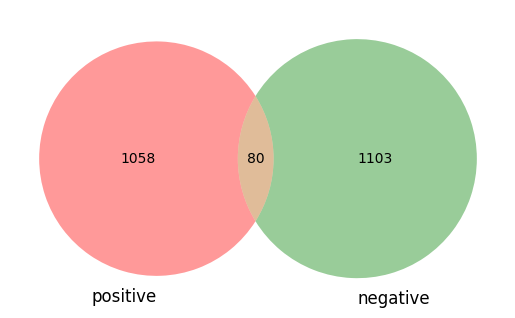

In [143]:
matplotlib_venn.venn2([positive, negative ], set_labels=["positive", "negative" ])

In [145]:
cross =positive & negative
len(cross)

80

In [146]:
negative= negative - cross

positive=pd.DataFrame(positive)
positive["y"]=1
negative=pd.DataFrame(negative)
negative["y"]=0

gene_list= pd.concat([positive, negative])
gene_list.columns=["gene", "y"]
gene_list

,gene,y
0,ENSG00000169057,1
1,ENSG00000185960,1
2,ENSG00000006377,1
3,ENSG00000137713,1
4,ENSG00000164604,1
...,...,...
1098,ENSG00000241635,0
1099,ENSG00000015285,0
1100,ENSG00000163093,0
1101,ENSG00000165730,0
